# Setup & Data

In [1]:
# Import dependencies
import aopy 
from aopy.data import db

import sys
import os
import warnings
from datetime import date, datetime, timedelta

import pickle
import h5py
import pandas as pd
from tqdm.notebook import tqdm, trange
from ipywidgets import interactive, widgets

import math
import numpy as np
import re
import scipy
from scipy import signal
from scipy.stats import zscore
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import base64
from jinja2 import Template

print('Dependencies loaded')

/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(
/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dependencies loaded


In [2]:
# Filepaths

data_dir = '/data/human'
preproc_dir = '/data/preprocessed-human'

db.BMI3D_DBNAME = "human"

sources = ['exp']

subject = 'MCP015'

In [24]:
# Load and tabulate preprocessed data

entries = db.lookup_mc_sessions(subject=subject)
subjects, ids, dates = db.list_entry_details(entries)

print(f"Session IDs: {ids}")

_, oop_metadata = aopy.data.load_preproc_exp_data(preproc_dir, subject, ids[4], dates[0])

df = aopy.data.tabulate_behavior_data_center_out(preproc_dir, subjects, ids, dates, 
                                                 metadata=['target_radius', 'session'])

oop_df = df[df['reach_completed'] & df['session'].isin(['b1','b2','b3'])]

Session IDs: (732, 733, 734, 735, 736, 737, 738)


  0%|          | 0/7 [00:00<?, ?it/s]

# Getting kinematic data in world coordinates

In [16]:
# Add cursor and hand trajectories (in world coordinates) for completed OOP reaches to the dataframe

oop_target_idx = df[df['reach_completed'] & df['session'].isin(['b1','b2','b3'])]['target_idx'].to_numpy()
num_targets = len(np.unique(oop_target_idx))
colors = sns.color_palette(n_colors=num_targets+1)

kin_segments_screenHand = aopy.data.bmi3d.tabulate_kinematic_data(
    preproc_dir, oop_df['subject'], oop_df['te_id'], oop_df['date'], oop_df['go_cue_time'], oop_df['reach_end_time'],
    datatype='user_screen'
)

kin_segments_cursor = aopy.data.bmi3d.tabulate_kinematic_data(
    preproc_dir, oop_df['subject'], oop_df['te_id'], oop_df['date'], oop_df['go_cue_time'], oop_df['reach_end_time'],
    datatype='cursor'
)

kin_segments_bmi3dHand = aopy.data.bmi3d.tabulate_kinematic_data(
    preproc_dir, oop_df['subject'], oop_df['te_id'], oop_df['date'], oop_df['go_cue_time'], oop_df['reach_end_time'],
    datatype='user_raw'
)

kin_segments_worldHand = aopy.data.bmi3d.tabulate_kinematic_data(
    preproc_dir, oop_df['subject'], oop_df['te_id'], oop_df['date'], oop_df['go_cue_time'], oop_df['reach_end_time'],
    datatype='user_world'
)

/home/aolab/leo/analyze/aopy/data/bmi3d.py:671: UserWarning: Raw hand position is not recommended for analysis. Use 'user_world' instead for 3D world coordinate inputs.
  warnings.warn("Raw hand position is not recommended for analysis. Use 'user_world' instead for 3D world coordinate inputs.")


# Getting and using experimental transformations

Text(0.5, 1.0, 'OOP Cursor')

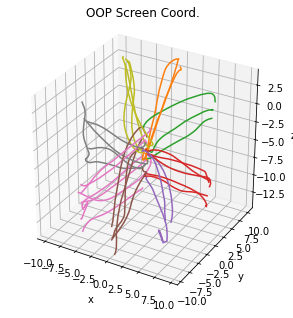

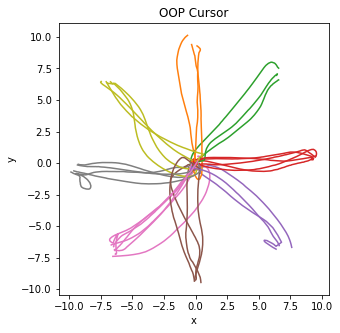

In [18]:
ax = plt.figure(figsize = (5,5)).add_subplot(projection='3d')
aopy.visualization.color_trajectories(kin_segments_screenHand[-32:], oop_target_idx[-32:], colors)
plt.title(f'OOP Screen Coord.')

ax = plt.figure(figsize = (5,5))
aopy.visualization.color_trajectories(kin_segments_cursor[-32:], oop_target_idx[-32:], colors)
plt.title(f'OOP Cursor')

Text(0.5, 0.92, 'User Data (World Coords.)')

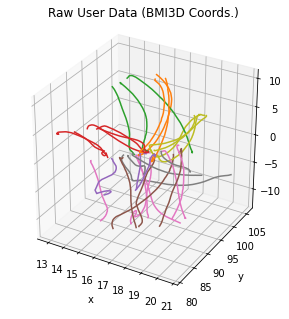

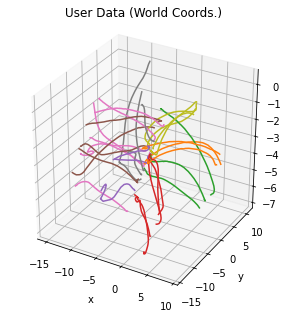

In [32]:
ax = plt.figure(figsize = (5,5)).add_subplot(projection='3d')
aopy.visualization.color_trajectories(kin_segments_bmi3dHand[-32:], oop_target_idx[-32:], colors)
plt.title(f'Raw User Data (BMI3D Coords.)')

ax = plt.figure(figsize = (5,5)).add_subplot(projection='3d')
aopy.visualization.color_trajectories(kin_segments_worldHand[-32:], oop_target_idx[-32:], colors)
plt.title(f'User Data (World Coords.)')

Text(0.5, 0.92, 'User Data (World Coords.) run through mapping')

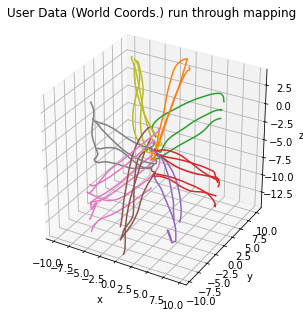

In [36]:
# Get and run world-coordinate user data through OOP mapping

oop_mapping = aopy.postproc.bmi3d.get_world_to_screen_mapping(
    exp_rotation=oop_metadata['exp_rotation'],
    x_rot=oop_metadata['perturbation_rotation_x'],
    y_rot=oop_metadata['pertubation_rotation'], # NOTE: this is a misspelled key, may want to fix it
    z_rot=oop_metadata['perturbation_rotation_z'],
    exp_scale=oop_metadata['scale']
)

kin_segments_mapped = [coords @ oop_mapping for coords in kin_segments_worldHand]

ax = plt.figure(figsize = (5,5)).add_subplot(projection='3d')
aopy.visualization.color_trajectories(kin_segments_mapped[-32:], oop_target_idx[-32:], colors)
plt.title(f'User Data (World Coords.) run through mapping')